In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt

# Constants
INPUT_SIZE = 1  # Assuming state is a scalar
HIDDEN_SIZE = 128  # Example hidden size
OUTPUT_SIZE = 1  # Assuming action is a scalar
GAMMA = 0.99  # Discount factor
EPISODES = 1000  # Number of episodes for training
DT = 0.1  # Time delta for your dynamical system
MAX_TIME=100 #maximum simulation time
EXCLUSION_BOUNDARY=10 #if the agent's state is out of a radius 10 from the 0 axis has lost

In [17]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.sigmoid = nn.Sigmoid()
        self.mean = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
        self.logstd = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
        self.log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        mean = self.mean(x)
        logstd = self.logstd(x)
        logstd = torch.clamp(logstd, min=-20, max=2)
        std = torch.exp(logstd)
        return mean, std

In [18]:
def select_action(state, policy):
    state = torch.from_numpy(state).float().unsqueeze(0)
    mean, std = policy(state)
    dist = Normal(mean, std)
    action = dist.sample()
    lp = dist.log_prob(action)
    policy.log_probs.append(lp)
    return action.item()

def finish_episode(policy, optimizer):
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + GAMMA * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-5)
    for log_prob, R in zip(policy.log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    tot_rew=sum(policy.rewards).item()
    del policy.rewards[:]
    del policy.log_probs[:]
    return tot_rew


def rew_fn(state):
    return 1 - 0.5 * state**2

def step(state, action):
    c_rew0 = rew_fn(state)
    state += (np.array([action]) * 0.2 + state * 0.05) * DT
    c_rew = rew_fn(state)
    reward = c_rew - c_rew0
    return state, reward


Episode 0, Total Reward: [-50.06857136]


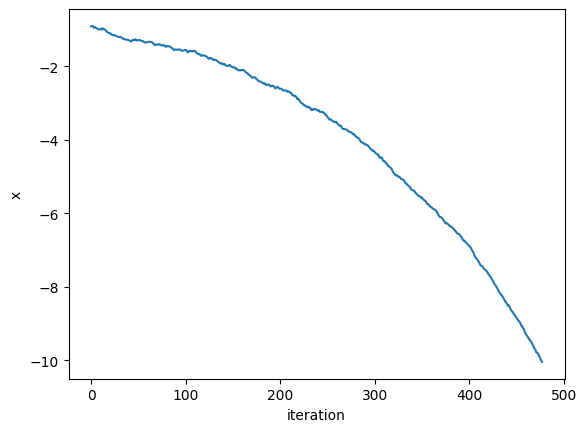

Episode 29, Total Reward: [-0.00240821]


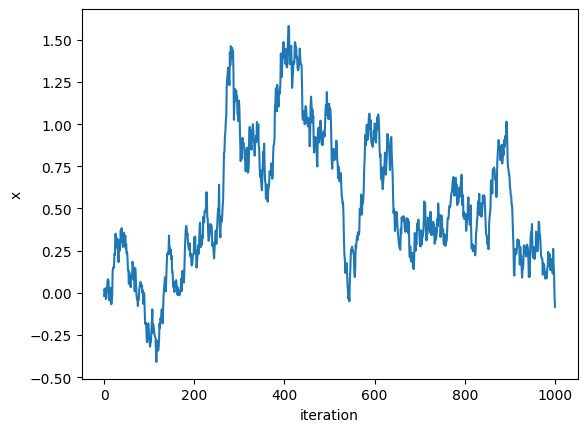

Episode 59, Total Reward: [0.1429436]


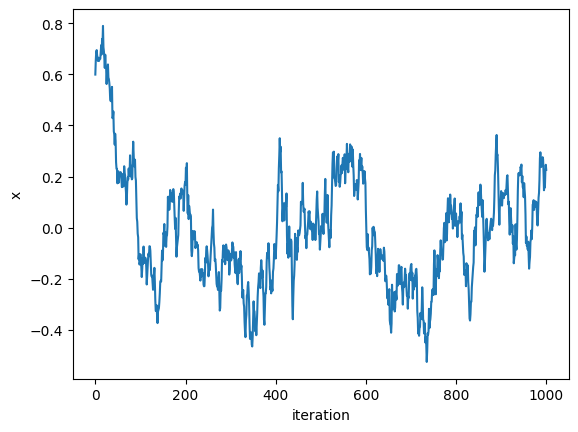

Episode 89, Total Reward: [0.12648574]


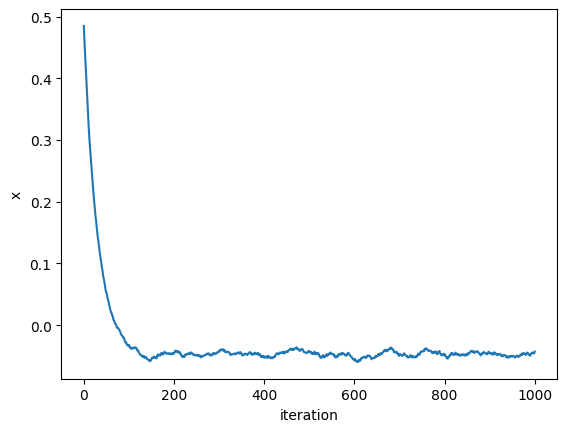

Episode 119, Total Reward: [0.24982574]


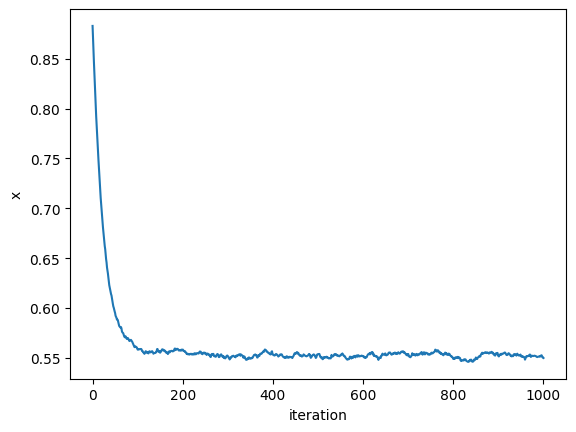

Episode 149, Total Reward: [-0.42404703]


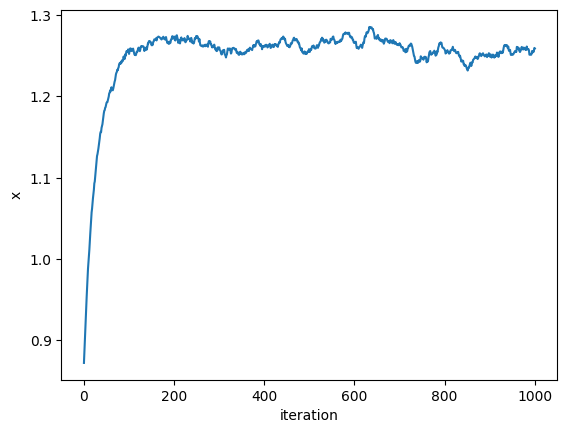

Episode 179, Total Reward: [0.16215847]


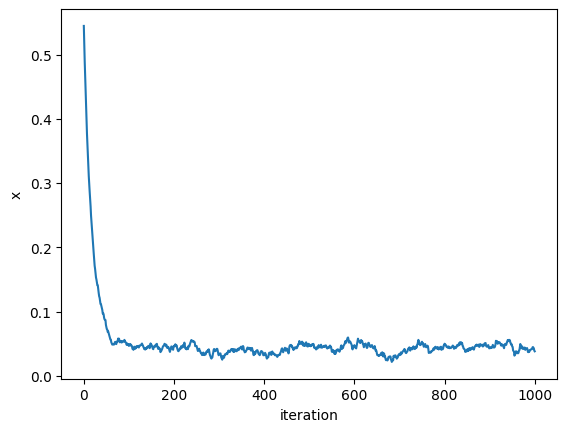

Episode 209, Total Reward: [0.01194503]


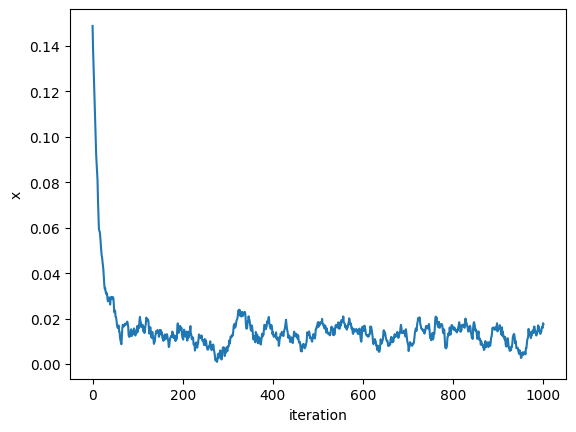

Episode 239, Total Reward: [0.22708007]


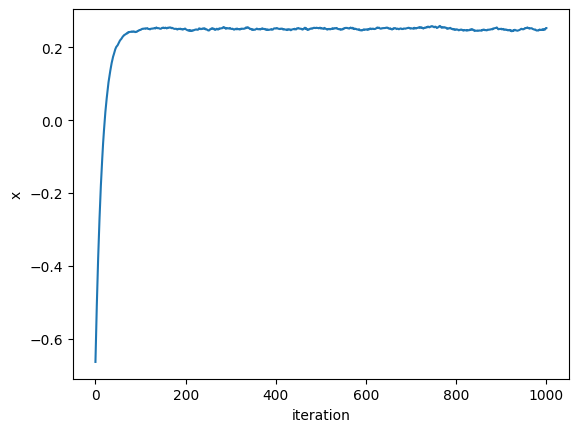

Episode 269, Total Reward: [0.01374781]


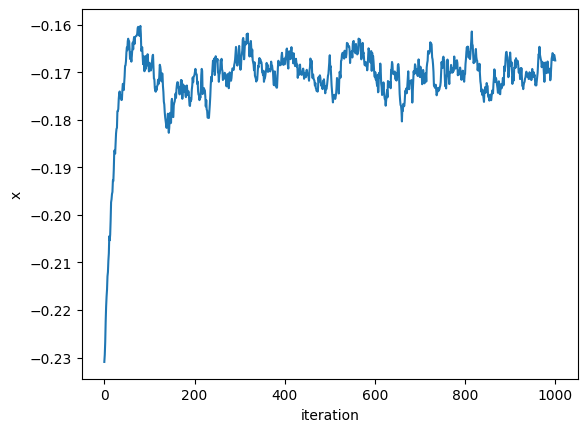

Episode 299, Total Reward: [0.01524626]


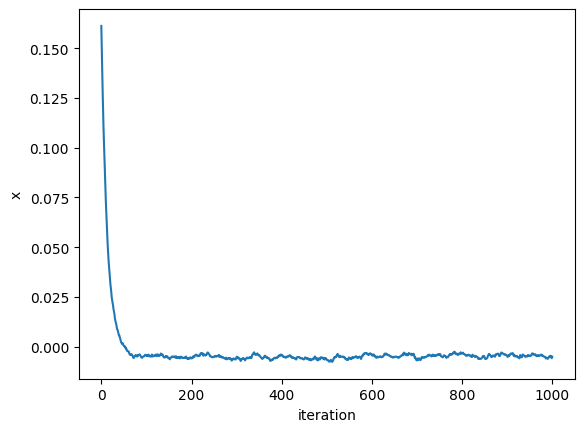

Episode 329, Total Reward: [0.25615432]


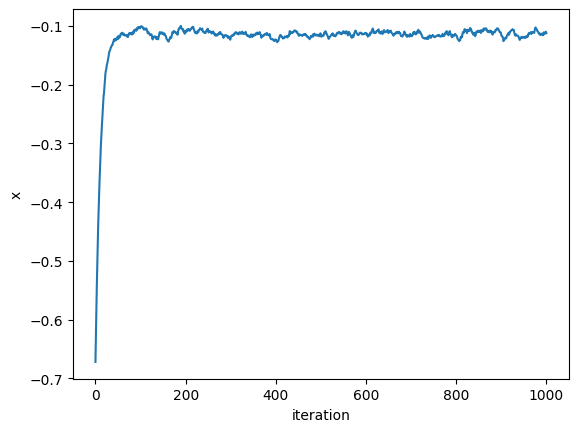

Episode 359, Total Reward: [-0.0012789]


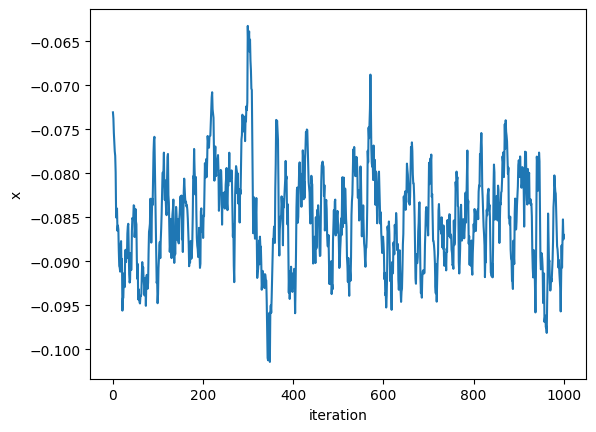

Episode 389, Total Reward: [0.02618275]


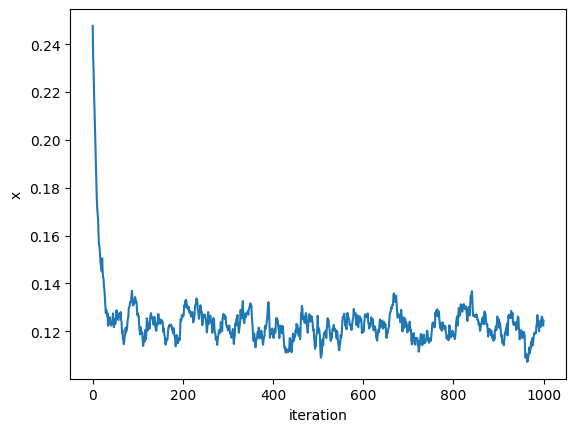

Episode 419, Total Reward: [0.04457679]


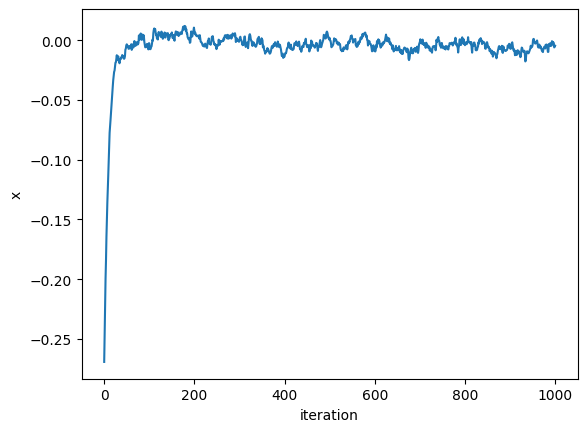

Episode 449, Total Reward: [0.34720812]


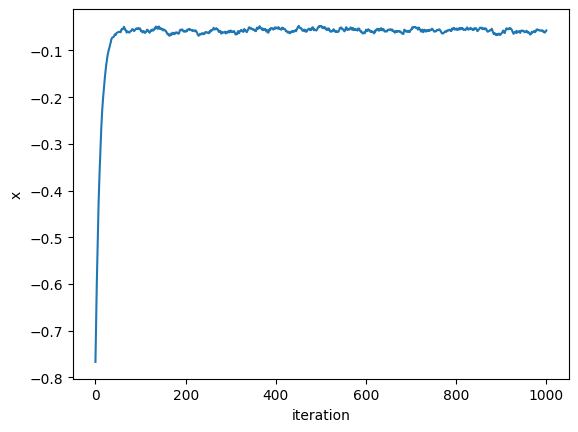

Episode 479, Total Reward: [0.36351666]


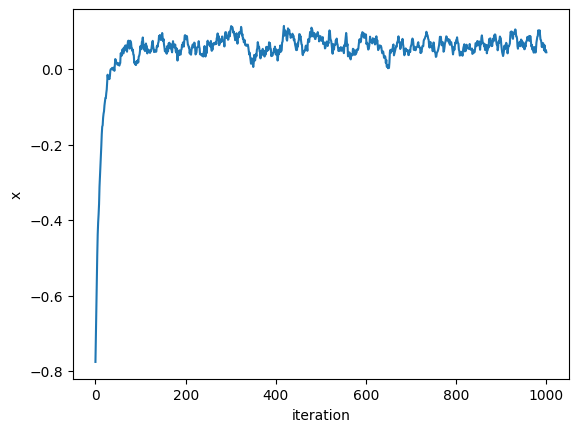

Episode 509, Total Reward: [0.40417145]


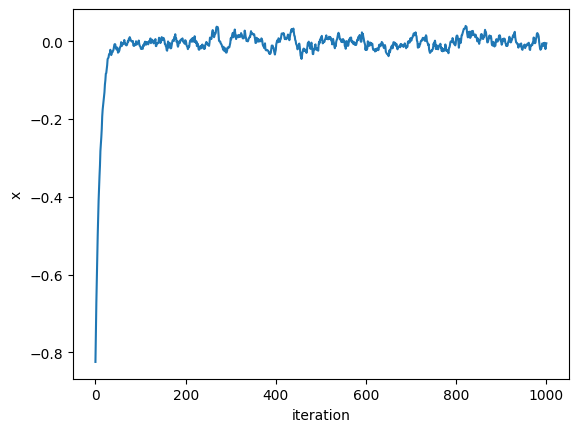

Episode 539, Total Reward: [0.00623515]


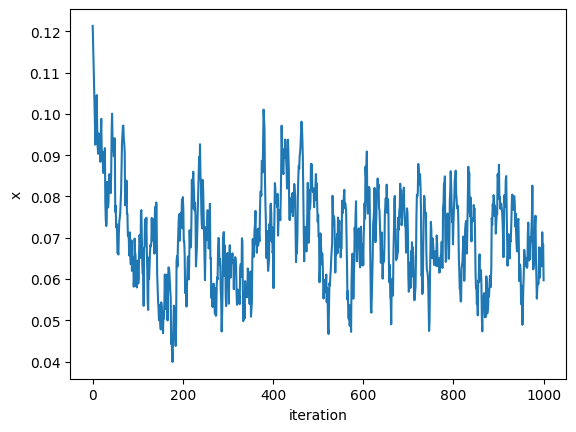

Episode 569, Total Reward: [0.01421355]


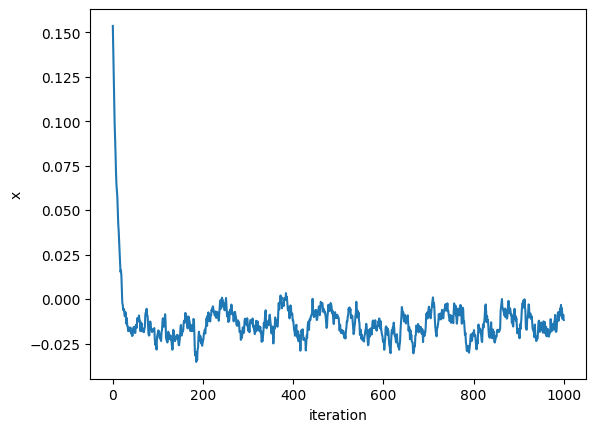

Episode 599, Total Reward: [0.47106302]


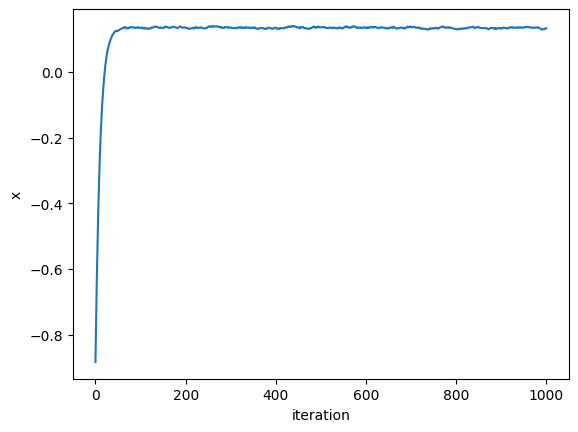

Episode 629, Total Reward: [0.37573225]


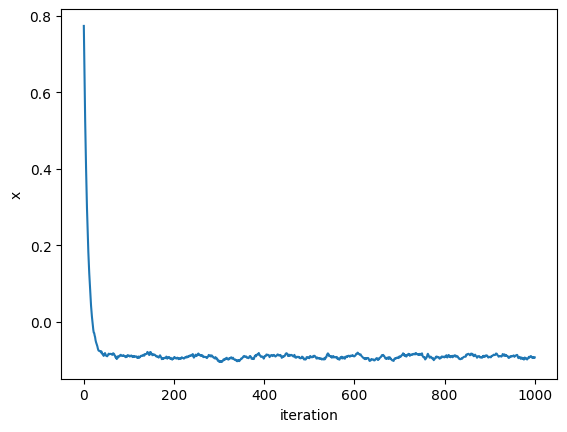

Episode 659, Total Reward: [0.15839851]


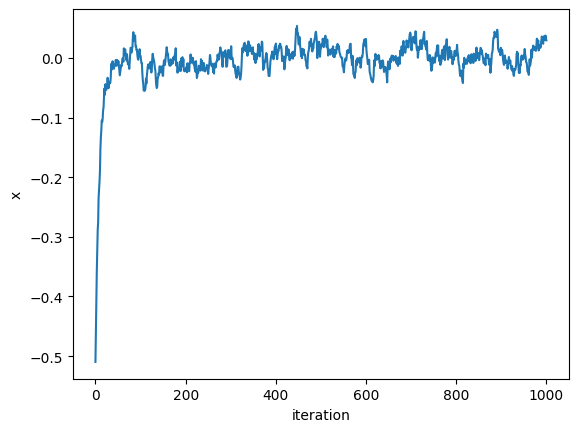

Episode 689, Total Reward: [0.05351504]


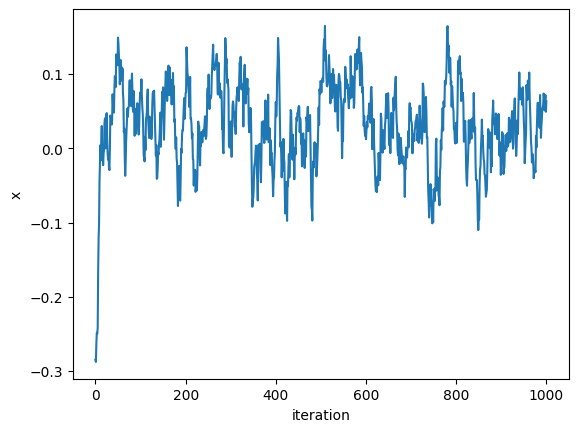

Episode 719, Total Reward: [0.02876289]


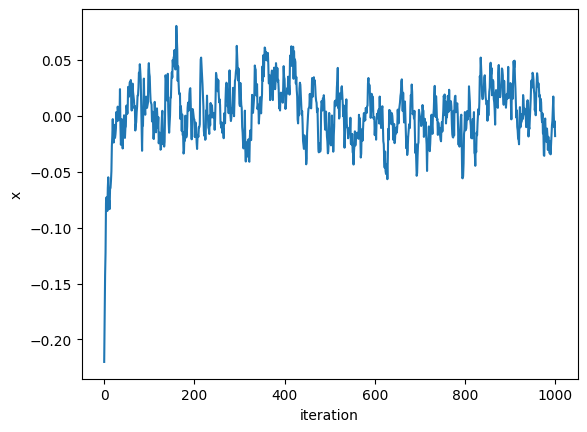

Episode 749, Total Reward: [0.20374819]


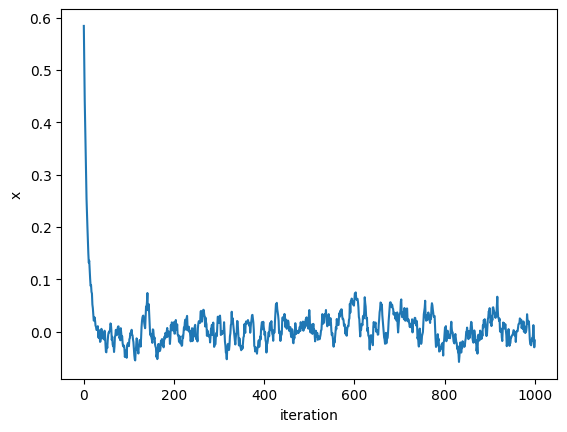

Episode 779, Total Reward: [0.23149615]


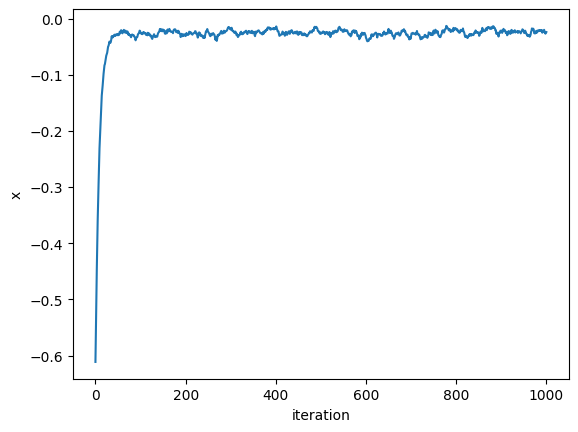

Episode 809, Total Reward: [0.13563527]


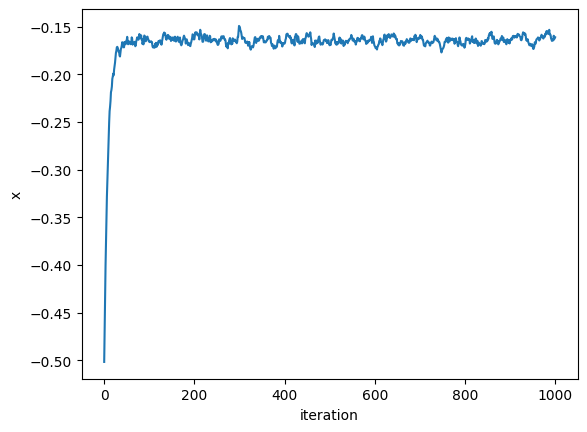

Episode 839, Total Reward: [0.25472086]


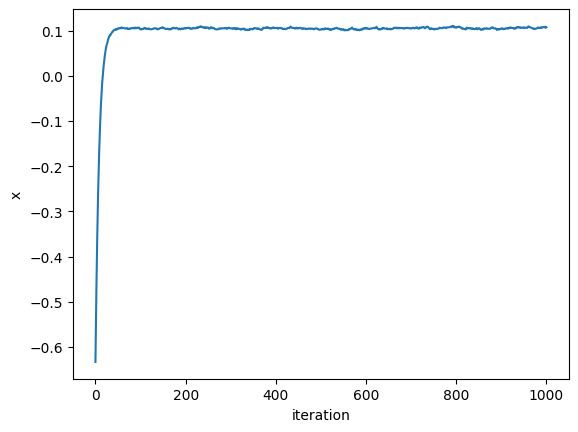

Episode 869, Total Reward: [-0.44633]


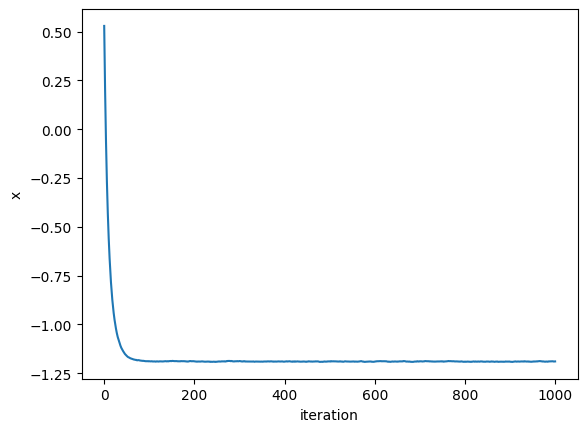

Episode 899, Total Reward: [-2.20246411]


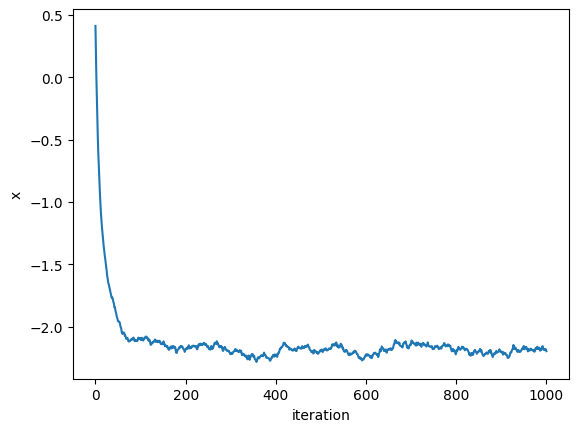

Episode 929, Total Reward: [-2.18204915]


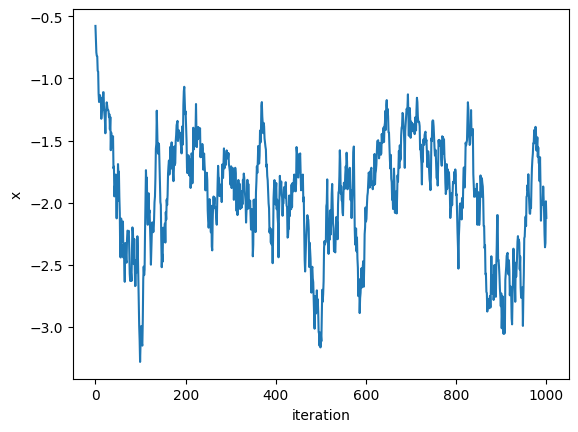

Episode 959, Total Reward: [-0.17252708]


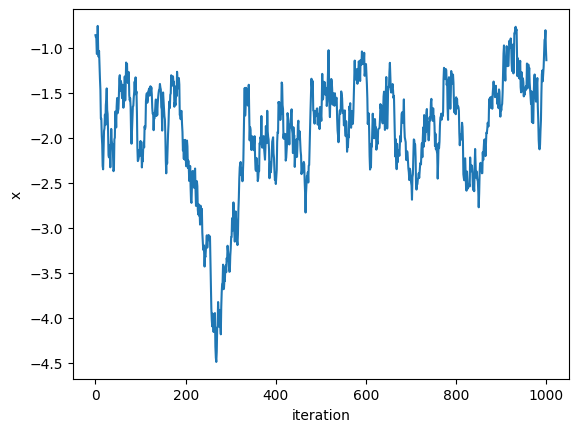

Episode 989, Total Reward: [-1.50824219]


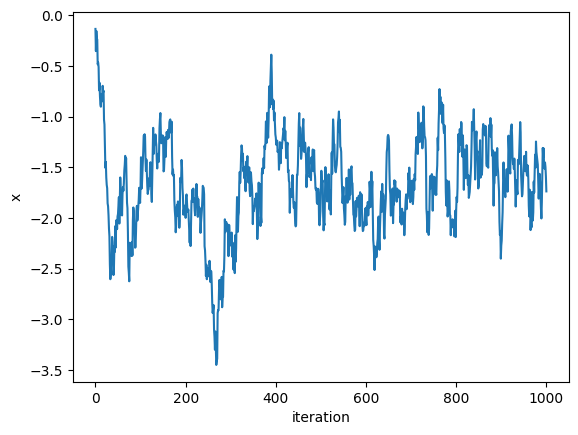

In [19]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=0.005)

reward_progress=[]
for episode in range(EPISODES):
    state = np.random.uniform(-1,1,1)  # Initialize state, adjust as needed
    time=0
    total_reward = 0
    done = False
    states=[]
    while not done:
        action = select_action(state, policy)
        state, reward = step(state, action)
        states.append(state[0])
        policy.rewards.append(reward)
        total_reward += reward
        time+=DT
        done = np.abs(state)>EXCLUSION_BOUNDARY or time>MAX_TIME
    finish_episode(policy, optimizer)
    reward_progress.append(total_reward)

    if (episode+1)%30==0 or episode==0:
        print(f'Episode {episode}, Total Reward: {total_reward}')
        plt.plot(states)
        plt.xlabel("iteration")
        plt.ylabel("x")
        plt.show()


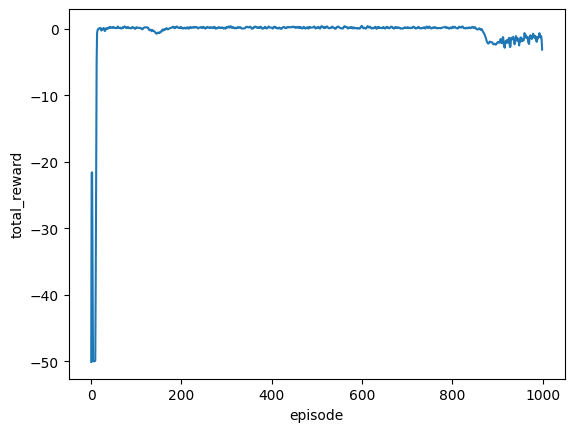

In [20]:
reward_progress[1:-1]=[0.333*(reward_progress[i]+reward_progress[i+1]+reward_progress[i-1]) for i in range(1,len(reward_progress)-1)]
plt.plot(reward_progress)
plt.xlabel("episode")
plt.ylabel("total_reward")
plt.show()

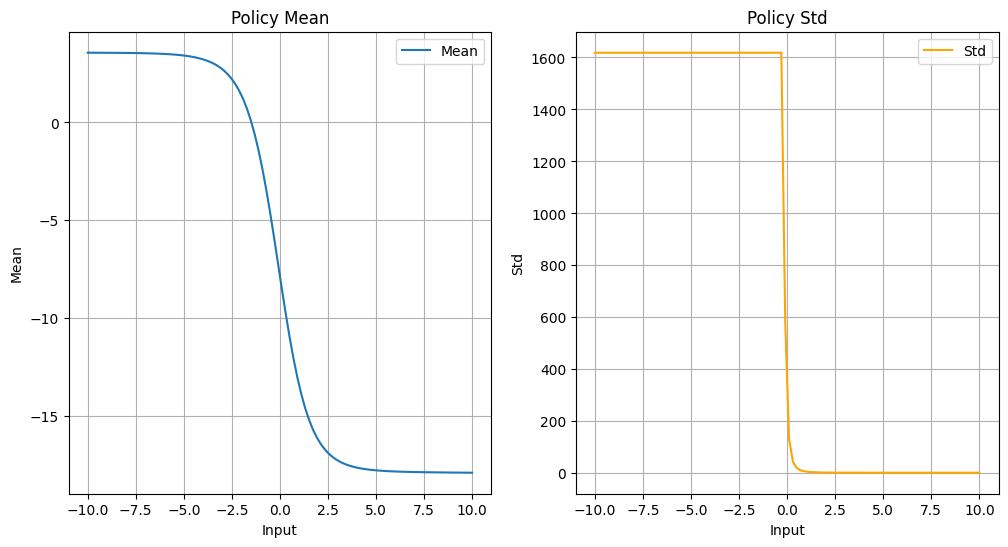

In [21]:
def plot_policy_means_stds(policy, input_range):
    inputs = np.linspace(input_range[0], input_range[1], 100)  # 100 sample points
    means, stds = [], []

    with torch.no_grad():
        for x in inputs:
            mean, std = policy(torch.tensor([x]).float())
            means.append(mean.item())
            stds.append(std.exp().item())  # std is the exponentiation of logstd

    plt.figure(figsize=(12, 6))

    # Plotting Mean
    plt.subplot(1, 2, 1)
    plt.plot(inputs, means, label='Mean')
    plt.xlabel('Input')
    plt.ylabel('Mean')
    plt.title('Policy Mean')
    plt.grid(True)
    plt.legend()

    # Plotting Std
    plt.subplot(1, 2, 2)
    plt.plot(inputs, stds, label='Std', color='orange')
    plt.xlabel('Input')
    plt.ylabel('Std')
    plt.title('Policy Std')
    plt.grid(True)
    plt.legend()

    plt.show()

# Call the function with your policy and desired input range
plot_policy_means_stds(policy, [-10, 10])